In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, KFold, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, PairwiseKernel, RBF

In [2]:
xl = pd.ExcelFile("BST_Data.xlsx")
data = xl.parse(xl.sheet_names[0]).iloc[:, 0:7]

split_date = '2017-07-01'

data_cv = data.dropna()
data_train = data[data.index < split_date].dropna()
data_test = data[data.index >= split_date].dropna()

CV_splits = 20
cv = TimeSeriesSplit(n_splits = CV_splits)

### Kernel Ridge: Linear + RBF

In [64]:
def Linear_plus_RBF():

    def kernel_function(_x_i, _x_j, c = 0.0, gamma = 1.0, w = 0.5, scale = 1.0):
        
        Linear = (c + np.dot(_x_i, _x_j))
        RBF = np.exp(-gamma * np.dot(_x_i-_x_j, _x_i-_x_j))
        
        K = (w*Linear + (1-w)*RBF) / scale
        return K

    return kernel_function

In [65]:
estm_s1 = make_pipeline(StandardScaler(), KernelRidge(kernel = Linear_plus_RBF()))

kernel_params = []
for c in [0.01, 0.5, 1]:
    for gamma in [0.2, 0.3, 0.4]:
        for w in [0.6, 0.7, 0.8]:
            for scale in [0.001, 0.005, 0.01]:
                kernel_params.append({'c': c, 'gamma': gamma, 'w': w, 'scale': scale})

tuned_parameters = [{'kernelridge__kernel_params': kernel_params}]

grid = GridSearchCV(estimator=estm_s1, param_grid=tuned_parameters, cv=cv, scoring="neg_mean_absolute_error")
grid.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

print("Grid MAE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.2f (+/-%0.2f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MAE score is %0.2f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

Grid MAE scores on development set:
-27617749819.34 (+/-44265988361.42) for {'kernelridge__kernel_params': {'scale': 0.001, 'w': 0.6, 'gamma': 0.2, 'c': 0.01}}
-22552693471.50 (+/-25820081097.00) for {'kernelridge__kernel_params': {'scale': 0.005, 'w': 0.6, 'gamma': 0.2, 'c': 0.01}}
-22465471727.69 (+/-24031516577.96) for {'kernelridge__kernel_params': {'scale': 0.01, 'w': 0.6, 'gamma': 0.2, 'c': 0.01}}
-25837380689.47 (+/-37973192208.42) for {'kernelridge__kernel_params': {'scale': 0.001, 'w': 0.7, 'gamma': 0.2, 'c': 0.01}}
-21680068798.40 (+/-23210045142.35) for {'kernelridge__kernel_params': {'scale': 0.005, 'w': 0.7, 'gamma': 0.2, 'c': 0.01}}
-21976079353.83 (+/-22356517168.19) for {'kernelridge__kernel_params': {'scale': 0.01, 'w': 0.7, 'gamma': 0.2, 'c': 0.01}}
-23314679212.33 (+/-29363505355.31) for {'kernelridge__kernel_params': {'scale': 0.001, 'w': 0.8, 'gamma': 0.2, 'c': 0.01}}
-20559180540.46 (+/-20217382640.55) for {'kernelridge__kernel_params': {'scale': 0.005, 'w': 0.8, 

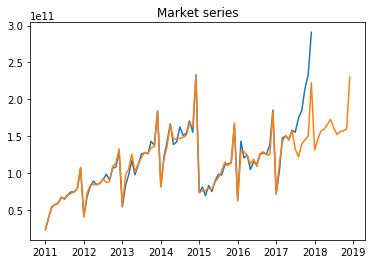

MAE on the test dataset is 56912452920.653.


In [66]:
estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_train.iloc[:, 0:6], data_train.iloc[:, 6])

plt.title('Market series')
plt.plot(data.index, data.iloc[:, 6])
plt.plot(data.index, estm_s1.predict(data.iloc[:, 0:6]))
plt.show()

y_pred = estm_s1.predict(data_test.iloc[:, 0:6])
y_true = data_test.iloc[:, 6]
score = mean_absolute_error(y_pred = y_pred, y_true = y_true)
print ('MAE on the test dataset is %0.3f.' % score)

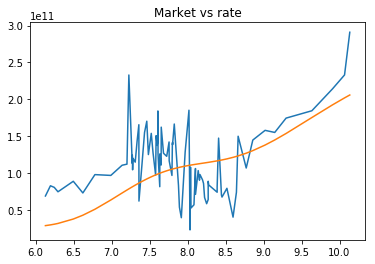

In [67]:
estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

data_elast = data_cv.copy()
for i in range(1, 6):
    data_elast.iloc[:, i] = data_elast.iloc[:, i].mean()

data_elast.sort_values(by = data_elast.columns[0], axis = 0, inplace = True)

plt.title('Market vs rate')
plt.plot(data_elast.iloc[:,0], data_elast.iloc[:, 6])
plt.plot(data_elast.iloc[:,0], estm_s1.predict(data_elast.iloc[:, 0:6]))
plt.show()

In [55]:
data_10 = data.iloc[-12:, 0:6].copy()
data_10.iloc[:, 0] = 1/0.1
m_10 = np.sum(estm_s1.predict(data_10))

data_11 = data.iloc[-12:, 0:6].copy()
data_11.iloc[:, 0] = 1/0.11
m_11 = np.sum(estm_s1.predict(data_11))

print ('Elasticity 10% vs 11%')
print ()
print (m_11 / m_10 - 1)

Elasticity 10% vs 11%

-0.262378317229


### Kernel Ridge: Linear + Rational Quadratic

In [18]:
def Linear_plus_Rational_Quadratic():

    def kernel_function(_x_i, _x_j, c = 0.0, a = 1.0, s = 1.0, w = 0.5, scale = 1.0):
        
        Linear = (c + np.dot(_x_i, _x_j))
        Rational_Quadratic = (1 + np.dot(_x_i-_x_j, _x_i-_x_j) / (2 * a * s**2))**(-a)
        
        K = (w*Linear + (1-w)*Rational_Quadratic) / scale
        return K

    return kernel_function

In [19]:
estm_s1 = make_pipeline(StandardScaler(), KernelRidge(kernel = Linear_plus_Rational_Quadratic()))

kernel_params = []
for a in [0.1, 0.125, 0.15]:
    for s in [3, 5, 7]:
        for w in [0.5, 0.6, 0.7]:
            for scale in [0.0001, 0.00025, 0.0005]:
                kernel_params.append({'a': a, 's': s, 'w': w, 'scale': scale})

tuned_parameters = [{'kernelridge__kernel_params': kernel_params}]

grid = GridSearchCV(estimator=estm_s1, param_grid=tuned_parameters, cv=cv, scoring="neg_mean_absolute_error")
grid.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

print("Grid MAE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MAE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

Grid MAE scores on development set:
-15703468783.528 (+/-19760459317.508) for {'kernelridge__kernel_params': {'scale': 0.0001, 's': 3, 'w': 0.5, 'a': 0.1}}
-15285891013.300 (+/-18573734816.893) for {'kernelridge__kernel_params': {'scale': 0.00025, 's': 3, 'w': 0.5, 'a': 0.1}}
-15357098565.164 (+/-19817734888.741) for {'kernelridge__kernel_params': {'scale': 0.0005, 's': 3, 'w': 0.5, 'a': 0.1}}
-15520211161.127 (+/-19177644488.964) for {'kernelridge__kernel_params': {'scale': 0.0001, 's': 3, 'w': 0.6, 'a': 0.1}}
-15299845120.043 (+/-18736592012.947) for {'kernelridge__kernel_params': {'scale': 0.00025, 's': 3, 'w': 0.6, 'a': 0.1}}
-15385367432.669 (+/-20524510707.814) for {'kernelridge__kernel_params': {'scale': 0.0005, 's': 3, 'w': 0.6, 'a': 0.1}}
-15339864169.424 (+/-18704131061.581) for {'kernelridge__kernel_params': {'scale': 0.0001, 's': 3, 'w': 0.7, 'a': 0.1}}
-15343940879.837 (+/-19271373906.454) for {'kernelridge__kernel_params': {'scale': 0.00025, 's': 3, 'w': 0.7, 'a': 0.1}}
-

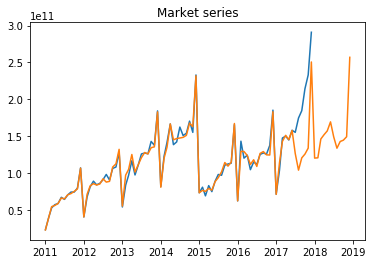

MAE on the test dataset is 65203719626.352.


In [20]:
estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_train.iloc[:, 0:6], data_train.iloc[:, 6])

plt.title('Market series')
plt.plot(data.index, data.iloc[:, 6])
plt.plot(data.index, estm_s1.predict(data.iloc[:, 0:6]))
plt.show()

y_pred = estm_s1.predict(data_test.iloc[:, 0:6])
y_true = data_test.iloc[:, 6]
score = mean_absolute_error(y_pred = y_pred, y_true = y_true)
print ('MAE on the test dataset is %0.3f.' % score)

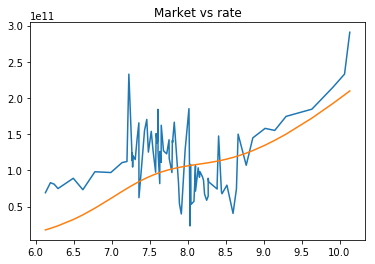

In [21]:
estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

data_elast = data_cv.copy()
for i in range(1, 6):
    data_elast.iloc[:, i] = data_elast.iloc[:, i].mean()

data_elast.sort_values(by = data_elast.columns[0], axis = 0, inplace = True)

plt.title('Market vs rate')
plt.plot(data_elast.iloc[:,0], data_elast.iloc[:, 6])
plt.plot(data_elast.iloc[:,0], estm_s1.predict(data_elast.iloc[:, 0:6]))
plt.show()

In [22]:
data_10 = data.iloc[-12:, 0:6].copy()
data_10.iloc[:, 0] = 1/0.1
m_10 = np.sum(estm_s1.predict(data_10))

data_11 = data.iloc[-12:, 0:6].copy()
data_11.iloc[:, 0] = 1/0.11
m_11 = np.sum(estm_s1.predict(data_11))

print ('Elasticity 10% vs 11%')
print ()
print (m_11 / m_10 - 1)

Elasticity 10% vs 11%

-0.263494655774


### Gaussian process: Linear + RBF

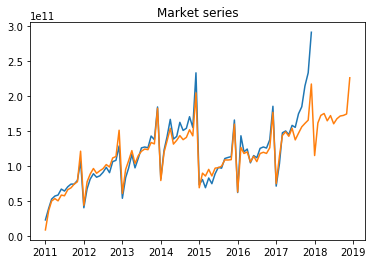

MAE on the test dataset is 44819627718.403.


In [161]:
K1 = WhiteKernel()
K2 = PairwiseKernel(metric='linear')
K3 = RBF()

K = (1.0 + K1) + (1.0 * K2) + (1.0 * K3) 

estm_s1 = make_pipeline(StandardScaler(), 
                        GaussianProcessRegressor(kernel=K, alpha=0, n_restarts_optimizer=10))
estm_s1.fit(data_train.iloc[:, 0:6], data_train.iloc[:, 6])

plt.title('Market series')
plt.plot(data.index, data.iloc[:, 6])
plt.plot(data.index, estm_s1.predict(data.iloc[:, 0:6]))
plt.show()

y_pred = estm_s1.predict(data_test.iloc[:, 0:6])
y_true = data_test.iloc[:, 6]
score = mean_absolute_error(y_pred = y_pred, y_true = y_true)
print ('MAE on the test dataset is %0.3f.' % score)

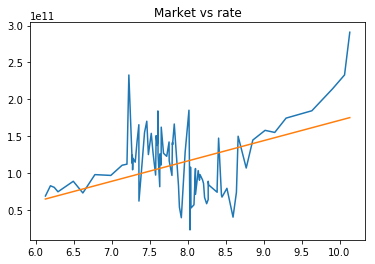

In [162]:
estm_s1.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

data_elast = data_cv.copy()
for i in range(1, 6):
    data_elast.iloc[:, i] = data_elast.iloc[:, i].mean()

data_elast.sort_values(by = data_elast.columns[0], axis = 0, inplace = True)

plt.title('Market vs rate')
plt.plot(data_elast.iloc[:,0], data_elast.iloc[:, 6])
plt.plot(data_elast.iloc[:,0], estm_s1.predict(data_elast.iloc[:, 0:6]))
plt.show()

In [163]:
data_10 = data.iloc[-12:, 0:6].copy()
data_10.iloc[:, 0] = 1/0.1
m_10 = np.sum(estm_s1.predict(data_10))

data_11 = data.iloc[-12:, 0:6].copy()
data_11.iloc[:, 0] = 1/0.11
m_11 = np.sum(estm_s1.predict(data_11))

print ('Elasticity 10% vs 11%')
print ()
print (m_11 / m_10 - 1)

Elasticity 10% vs 11%

-0.127268643728


### AdaBoost (3-rd order poly)

In [55]:
base_estimator = make_pipeline(StandardScaler(), KernelRidge(kernel = 'poly', degree = 3))

estm_s2 = AdaBoostRegressor(base_estimator = base_estimator, loss = "exponential")
tuned_parameters = [{'n_estimators': [10, 25, 50, 75, 100],
                     'base_estimator__kernelridge__gamma': [0.01, 0.1, 0.5]}]


grid = GridSearchCV(estimator=estm_s2, param_grid=tuned_parameters, cv=cv, scoring="neg_mean_absolute_error")
grid.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

print("Grid MAE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MAE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

Grid MAE scores on development set:
-26351939941.421 (+/-36880697885.608) for {'n_estimators': 10, 'base_estimator__kernelridge__gamma': 0.01}
-27476678391.639 (+/-46469670619.913) for {'n_estimators': 25, 'base_estimator__kernelridge__gamma': 0.01}
-24787667577.026 (+/-38264784718.083) for {'n_estimators': 50, 'base_estimator__kernelridge__gamma': 0.01}
-24537789113.039 (+/-39769765490.221) for {'n_estimators': 75, 'base_estimator__kernelridge__gamma': 0.01}
-27411606661.732 (+/-46156450131.573) for {'n_estimators': 100, 'base_estimator__kernelridge__gamma': 0.01}
-28083821151.900 (+/-67677869177.423) for {'n_estimators': 10, 'base_estimator__kernelridge__gamma': 0.1}
-25753830306.790 (+/-59957882959.515) for {'n_estimators': 25, 'base_estimator__kernelridge__gamma': 0.1}
-34640080384.379 (+/-115029794450.638) for {'n_estimators': 50, 'base_estimator__kernelridge__gamma': 0.1}
-23406390982.625 (+/-49993930492.182) for {'n_estimators': 75, 'base_estimator__kernelridge__gamma': 0.1}
-23

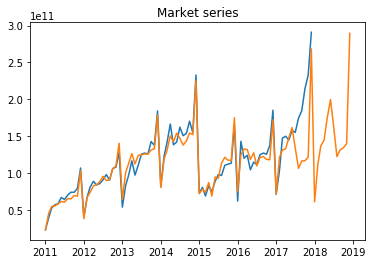

MAE on the test dataset is 64686841070.833.


In [56]:
estm_s2.set_params(**grid.best_params_)
estm_s2.fit(data_train.iloc[:, 0:6], data_train.iloc[:, 6])

plt.title('Market series')
plt.plot(data.index, data.iloc[:, 6])
plt.plot(data.index, estm_s2.predict(data.iloc[:, 0:6]))
plt.show()

y_pred = estm_s2.predict(data_test.iloc[:, 0:6])
y_true = data_test.iloc[:, 6]
score = mean_absolute_error(y_pred = y_pred, y_true = y_true)
print ('MAE on the test dataset is %0.3f.' % score)

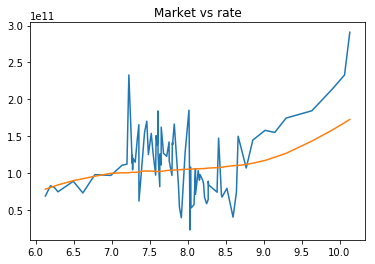

In [57]:
estm_s2.set_params(**grid.best_params_)
estm_s2.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

data_elast = data_cv.copy()
for i in range(1, 6):
    data_elast.iloc[:, i] = data_elast.iloc[:, i].mean()

data_elast.sort_values(by = data_elast.columns[0], axis = 0, inplace = True)

plt.title('Market vs rate')
plt.plot(data_elast.iloc[:,0], data_elast.iloc[:, 6])
plt.plot(data_elast.iloc[:,0], estm_s2.predict(data_elast.iloc[:, 0:6]))
plt.show()

In [58]:
data_10 = data.iloc[-12:, 0:6].copy()
data_10.iloc[:, 0] = 1/0.1
m_10 = np.sum(estm_s2.predict(data_10))

data_11 = data.iloc[-12:, 0:6].copy()
data_11.iloc[:, 0] = 1/0.11
m_11 = np.sum(estm_s2.predict(data_11))

print ('Elasticity 10% vs 11%')
print ()
print (m_11 / m_10 - 1)

Elasticity 10% vs 11%

-0.216934662857


### Gradient boosting regression

In [27]:
estm_s2 = GradientBoostingRegressor(learning_rate = 0.1, max_features = 'auto', max_depth = 2)
tuned_parameters = [{'n_estimators': [100, 125, 150, 175, 200, 225, 250]}]


grid = GridSearchCV(estimator=estm_s2, param_grid=tuned_parameters, cv=cv, scoring="neg_mean_absolute_error")
grid.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

print("Grid MAE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MAE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

Grid MAE scores on development set:
-22189937188.441 (+/-38637615635.039) for {'n_estimators': 100}
-22341418819.919 (+/-38786749556.694) for {'n_estimators': 125}
-22129726624.282 (+/-38507693036.829) for {'n_estimators': 150}
-21975470332.976 (+/-37997281931.228) for {'n_estimators': 175}
-21985003094.313 (+/-38142073888.780) for {'n_estimators': 200}
-22016414722.440 (+/-37953829886.826) for {'n_estimators': 225}
-22139269634.218 (+/-37872028352.927) for {'n_estimators': 250}

Best MAE score is -21975470332.976. Best parameters set found on development set:
{'n_estimators': 175}


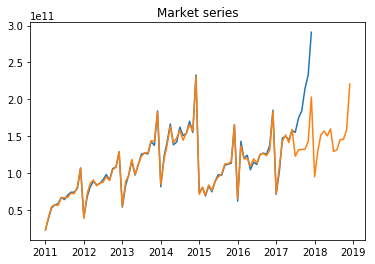

MAE on the test dataset is 64553439749.879.


In [28]:
estm_s2.set_params(**grid.best_params_)
estm_s2.fit(data_train.iloc[:, 0:6], data_train.iloc[:, 6])

plt.title('Market series')
plt.plot(data.index, data.iloc[:, 6])
plt.plot(data.index, estm_s2.predict(data.iloc[:, 0:6]))
plt.show()

y_pred = estm_s2.predict(data_test.iloc[:, 0:6])
y_true = data_test.iloc[:, 6]
score = mean_absolute_error(y_pred = y_pred, y_true = y_true)
print ('MAE on the test dataset is %0.3f.' % score)

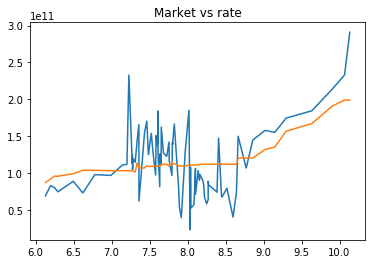

In [29]:
estm_s2.set_params(**grid.best_params_)
estm_s2.fit(data_cv.iloc[:, 0:6], data_cv.iloc[:, 6])

data_elast = data_cv.copy()
for i in range(1, 6):
    data_elast.iloc[:, i] = data_elast.iloc[:, i].mean()

data_elast.sort_values(by = data_elast.columns[0], axis = 0, inplace = True)

plt.title('Market vs rate')
plt.plot(data_elast.iloc[:,0], data_elast.iloc[:, 6])
plt.plot(data_elast.iloc[:,0], estm_s2.predict(data_elast.iloc[:, 0:6]))
plt.show()

In [30]:
data_10 = data.iloc[-12:, 0:6].copy()
data_10.iloc[:, 0] = 1/0.1
m_10 = np.sum(estm_s2.predict(data_10))

data_11 = data.iloc[-12:, 0:6].copy()
data_11.iloc[:, 0] = 1/0.11
m_11 = np.sum(estm_s2.predict(data_11))

print ('Elasticity 10% vs 11%')
print ()
print (m_11 / m_10 - 1)

Elasticity 10% vs 11%

-0.255877381722
